In [136]:
from typing import Optional

## Creating a tensor 
We can't do any differentiation if we don't have any numbers to differentiate, so first we need to create an object that we can apply operations to. We'll want to include some special behaviour for these numbers so we can't just use a python builtin like a `float`. Instead, we'll create an object which we'll call a `Tensor`:

In [115]:
class Tensor:
    """
    A number
    """

    def __init__(self, value: float):
        self.value = value

Next we'll need some simple operations we want to perform: addition, subtraction and multiplication.

In [116]:
def _add(a: Tensor, b: Tensor):
    """
    Add two tensors
    """
    return Tensor(a.value + b.value)


def _sub(a: Tensor, b: Tensor):
    """
    Subtract tensor b from tensor a
    """
    return Tensor(a.value - b.value)


def _mul(a: Tensor, b: Tensor):
    """
    Multiply two tensors
    """
    return Tensor(a.value * b.value)

We can use our operations as follows:

In [117]:
a = Tensor(3)
b = Tensor(4)

# This will raise an error if
# we are incorrect
assert _add(a, b).value == 7
assert _sub(a, b).value == -1
assert _mul(a, b).value == 12

## Scalar derivatives
Before we start doing full matrix derivatives, lets start by figuring out the derivatives of scalars. The simplest of these is the derivative of a tensor with respect to (wrt) itself:
$$\frac{dx}{dx} = 1$$

A more interesting case is the derivative of two tensors added together (note we are using partial derivatives because our function has multiple inputs):
$$f(x, y) = x + y$$
$$\frac{\partial f}{\partial x} = 1$$
$$\frac{\partial f}{\partial y} = 1$$

We can do a similar thing for multiplication

|$f(x, y)$|$\frac{\partial f}{\partial x}$|$\frac{\partial f}{\partial y}$|
|-|-|-|
|$x + y$|$1$|$1$|
|$x \times y$|$y$|$x$|

This means that if we have a variable produced by one of our functions, we can differentiate it wrt one of its inputs. If we make a `Tensor` from an operation, we need to store the derivative function in the `Tensor`.

We'll add two new attributes to our `Tensor`: `args` `derivatives` and `grad`. If the tensor is the output of an operation, then `args` will store the arguments to the operation and `derivatives` will store the derivatives wrt each input. If the tensor is an input to an operation, `grad` will store the dervative once we've actually calculated it.

In [130]:
class Tensor:
    """
    A number that can be differentiated
    """
    # If the tensor was made by an operation, the operation arguments
    # are stored in args
    args: tuple[Tensor]
    # If the tensor was made by an operation, the derivatives wrt
    # operation inputs are stored in
    derivatives: tuple[Tensor]
    # The derivative we have calculated
    grad: Optional[Tensor] | None = None

    def __init__(self, value: float):
        self.value = value

For example, if we have 

In [119]:
a = Tensor(3)
b = Tensor(4)

output = _mul(a, b)

Then `output.args` and `output.derivates` should be equal to should be set to:

```python
output.args == (Tensor(3), Tensor(4))
output.derivatives == (
    b,  # derivative of output wrt a is b
    a,  # derivative of output wrt b is a
)
```

Once we have actually computed the derivatives, then the derivative of `output` wrt `a` will be stored in `a.grad` and should be equal to `b` (which is 4 in this case). 

We know that we've done everything right once these tests pass (after computing the derivatives):

In [120]:
def test_can_differentiate_multiply_op():
    a = Tensor(3)
    b = Tensor(4)

    output = _mul(a, b)
    # TODO: differentiate here

    assert output.args == (a, b)
    assert output.derivatives == (b, a)
    assert a.grad == b
    assert b.grad == a

We're now able to modify our original operations to store the derivatives correctly

In [121]:
def _add(a: Tensor, b: Tensor):
    """
    Add two tensors
    """
    result = Tensor(a.value + b.value)
    result.derivatives = (Tensor(1), Tensor(1))
    result.args = (a, b)
    return result


def _sub(a: Tensor, b: Tensor):
    """
    Subtract tensor b from a
    """
    result = Tensor(a.value - b.value)
    result.derivatives = (Tensor(1), Tensor(-1))
    result.args = (a, b)
    return result


def _mul(a: Tensor, b: Tensor):
    """
    Multiply two tensors
    """
    result = Tensor(a.value * b.value)
    result.derivatives = (b, a)
    result.args = (a, b)
    return result

We can now add a function to our `Tensor` that will actually calculate the derivatives for each of the function arguments. Pytorch calls this function `backward` so we'll do the same.

In [131]:
class Tensor:
    """
    A number that can be differentiated
    """
    # If the tensor was made by an operation, the operation arguments
    # are stored in args
    args: tuple[Tensor]
    # If the tensor was made by an operation, the derivatives wrt
    # operation inputs are stored in
    derivatives: tuple[Tensor]
    # The derivative we have calculated
    grad: Optional[Tensor] | None = None

    def __init__(self, value: float):
        self.value = value

    def backward(self):
        if self.args is None or self.derivatives is None:
            raise ValueError(
                "Cannot differentiate a Tensor that is not a function of other Tensors"
            )

        for arg, derivative in zip(self.args, self.derivatives):
            arg.grad = derivative

We can now run our tests and see if it works

In [132]:
a = Tensor(3)
b = Tensor(4)

output = _mul(a, b)
output.backward()


assert output.args == (a, b)
assert output.derivatives[0] == b
assert output.derivatives[1] == a
assert a.grad == b
assert b.grad == a

So far so good, lets try nesting operations.

In [135]:
a = Tensor(3)
b = Tensor(4)

output_1 = _mul(a, b)
output_2 = _add(a, output_1)

output_2.backward()

assert b.grad == a, b.grad

AssertionError: None

Something has gone wrong. We should have got `a` as the derivative for `b` but we got `None` instead. Looking through the `.backward()` function, we can see that we can only handle single functions. To get this example working, we'll need to to calculate derivatives through multiple functions.

## Chaining Functions Together

To calculate derivates of nested functions, we can use another rule from calculus: The Chain Rule.

For a variable $z$ generated by nested functions $f$ and $g$ such that
$$z = f(g(x))$$

Then the derivative of $z$ wrt $x$ is:
$$\frac{\partial z}{\partial x} = \frac{\partial f(u)}{\partial u} \frac{\partial g(x)}{\partial x}$$

Here, $u$ is a kind of dummy variable.  $\frac{\partial f(u)}{\partial u}$ means the derivative of $f$ wrt its input.

For example, if 

$$f(x) = g(x)^2$$
Then we can define $u=g(x)$ and rewrite $f$ in terms of u 
$$f(u) = u^2 \implies \frac{\partial f(u)}{\partial u} = 2u = 2 g(x)$$

### Multiple Variables
The chain rule works as you might expect for functions of multiple variables. When differentiating wrt a variable, we can treat the other variables as constant and differentiate as normal
$$z = f(g(x), h(y))$$

$$\frac{\partial z}{\partial x} = \frac{\partial f(u)}{\partial u} \frac{\partial g(x)}{\partial x}$$
$$\frac{\partial z}{\partial y} = \frac{\partial f(u)}{\partial u} \frac{\partial h(y)}{\partial y}$$

If we have different functions that take the same input, we differentiate each of them individually and then add them together

$$z = f(g(x), h(x))$$

We get
$$\frac{\partial z}{\partial x} = \frac{\partial f(u)}{\partial u}\frac{\partial g(x)}{\partial x} + \frac{\partial f(u)}{\partial u}\frac{\partial h(x)}{\partial x}$$

### More than 2 functions
If we chain 3 functions together, we still just multiply the derivatives for each function together:

$$\frac{\partial z}{\partial x} = \frac{\partial f(u)}{\partial u} \frac{\partial g(x)}{\partial x} = \frac{\partial f(u)}{\partial u} \frac{\partial g(u)}{\partial u}\frac{\partial h(x)}{\partial x}$$

And this generalises to any amount of nesting

$$z = f_1(f_2(....f_{n-1}(f_n(x))...)) \implies \frac{\partial z}{\partial x} = \frac{\partial f_1(u)}{\partial u}\frac{\partial f_2(u)}{\partial u}...\frac{\partial f_{n-1}(u)}{\partial u}\frac{\partial f_{n}(x)}{\partial x}$$

### A picture is worth a thousand equations
As you probably noticed, the maths is starting to get quite dense. When we start working with neural networks, we can easily get 100s or 1000s of functions deep so, to get a handle on things, we'll need a different strategy. Helpfully, there is one: Diagrammatic formulae.

We can start with some rules:

Variables are represented with circles and operations are represented with boxes

<center>
    <div>
        <img src="images/variable_and_box.png" width="400"/></br>
    </div>
</center>


Inputs to an operation are represented with arrows that point to the operation box. Outputs point away. For example, here is the diagram for $z = mx$
<center>
    <div>
        <img src="images/z_eq_mx.png" width="300"/></br>
    </div>
</center>

And thats it! All of the equations we'll be working with can be represented graphically using these 4 rules. To try it out, let's draw the diagram for a more complex formula:

<center>
    <div>
        <img src="images/square_error.png" width="500"/></br>
    </div>
</center>

The real power of these diagrams is that they can also help us with our derivatives. For a single operation, we can flip the direction of the arrows and then label the (now outgoing) arrows with the derivative wrt to the input that they point to. For example, we transform the diagram for $z = mx$ as follows:

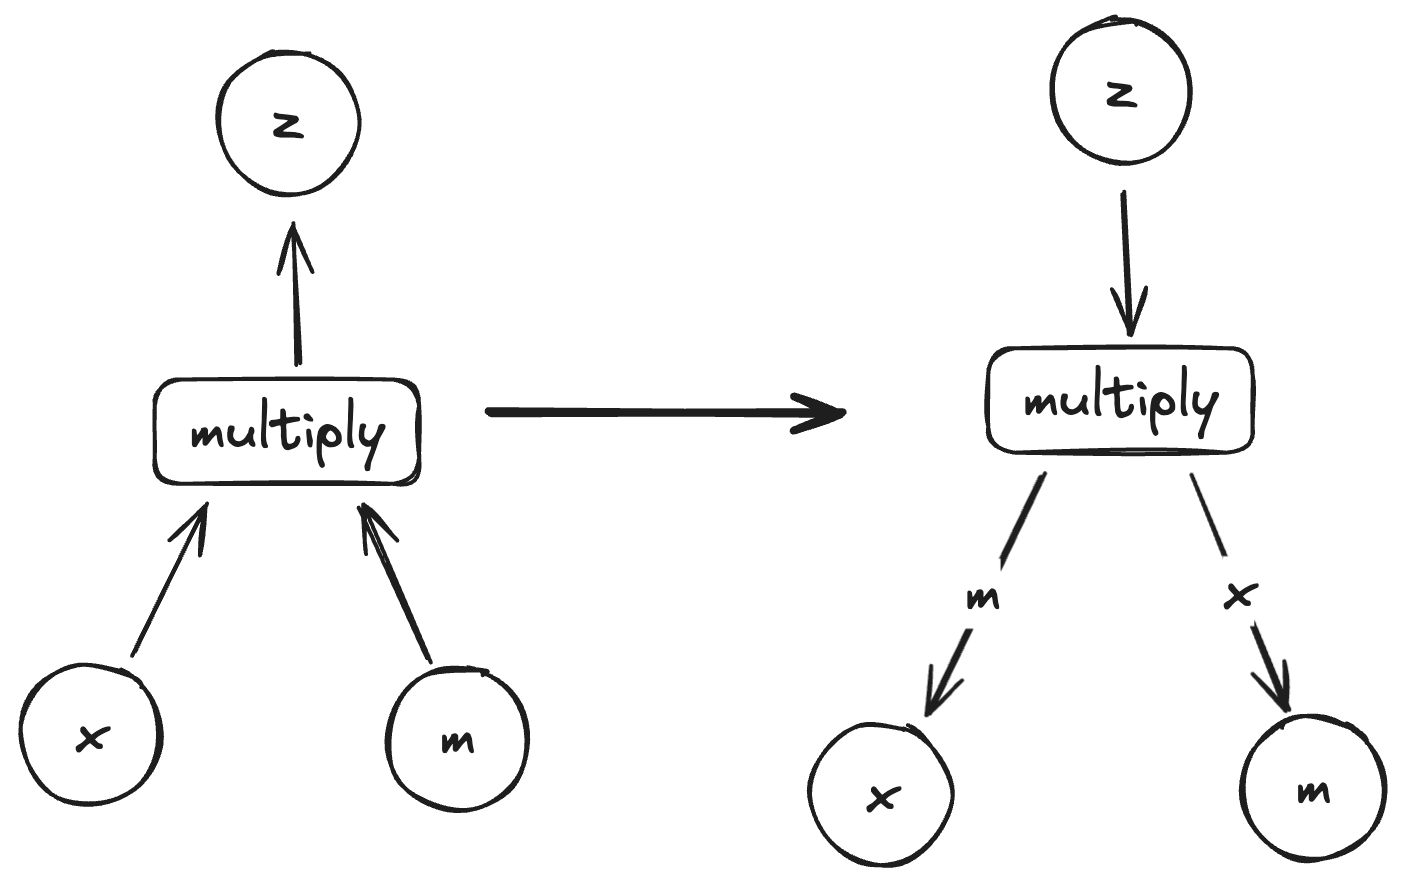

Now, we can calculate $\frac{\partial z}{\partial x}$ by simply following the path from $z$ to $x$ and keeping track of the derivative we pass on the way. This also works for $\frac{\partial z}{\partial m}$

On its own, this isn't very helpful. However, as we learnt above, if we have a variable that is produced from nested functions, we can differentiate it by multiplying the derivatives for each of the functions together. If we do the same arrow flipping and drawing derivatives operation that we did earlier, for example with $z = mx + c$

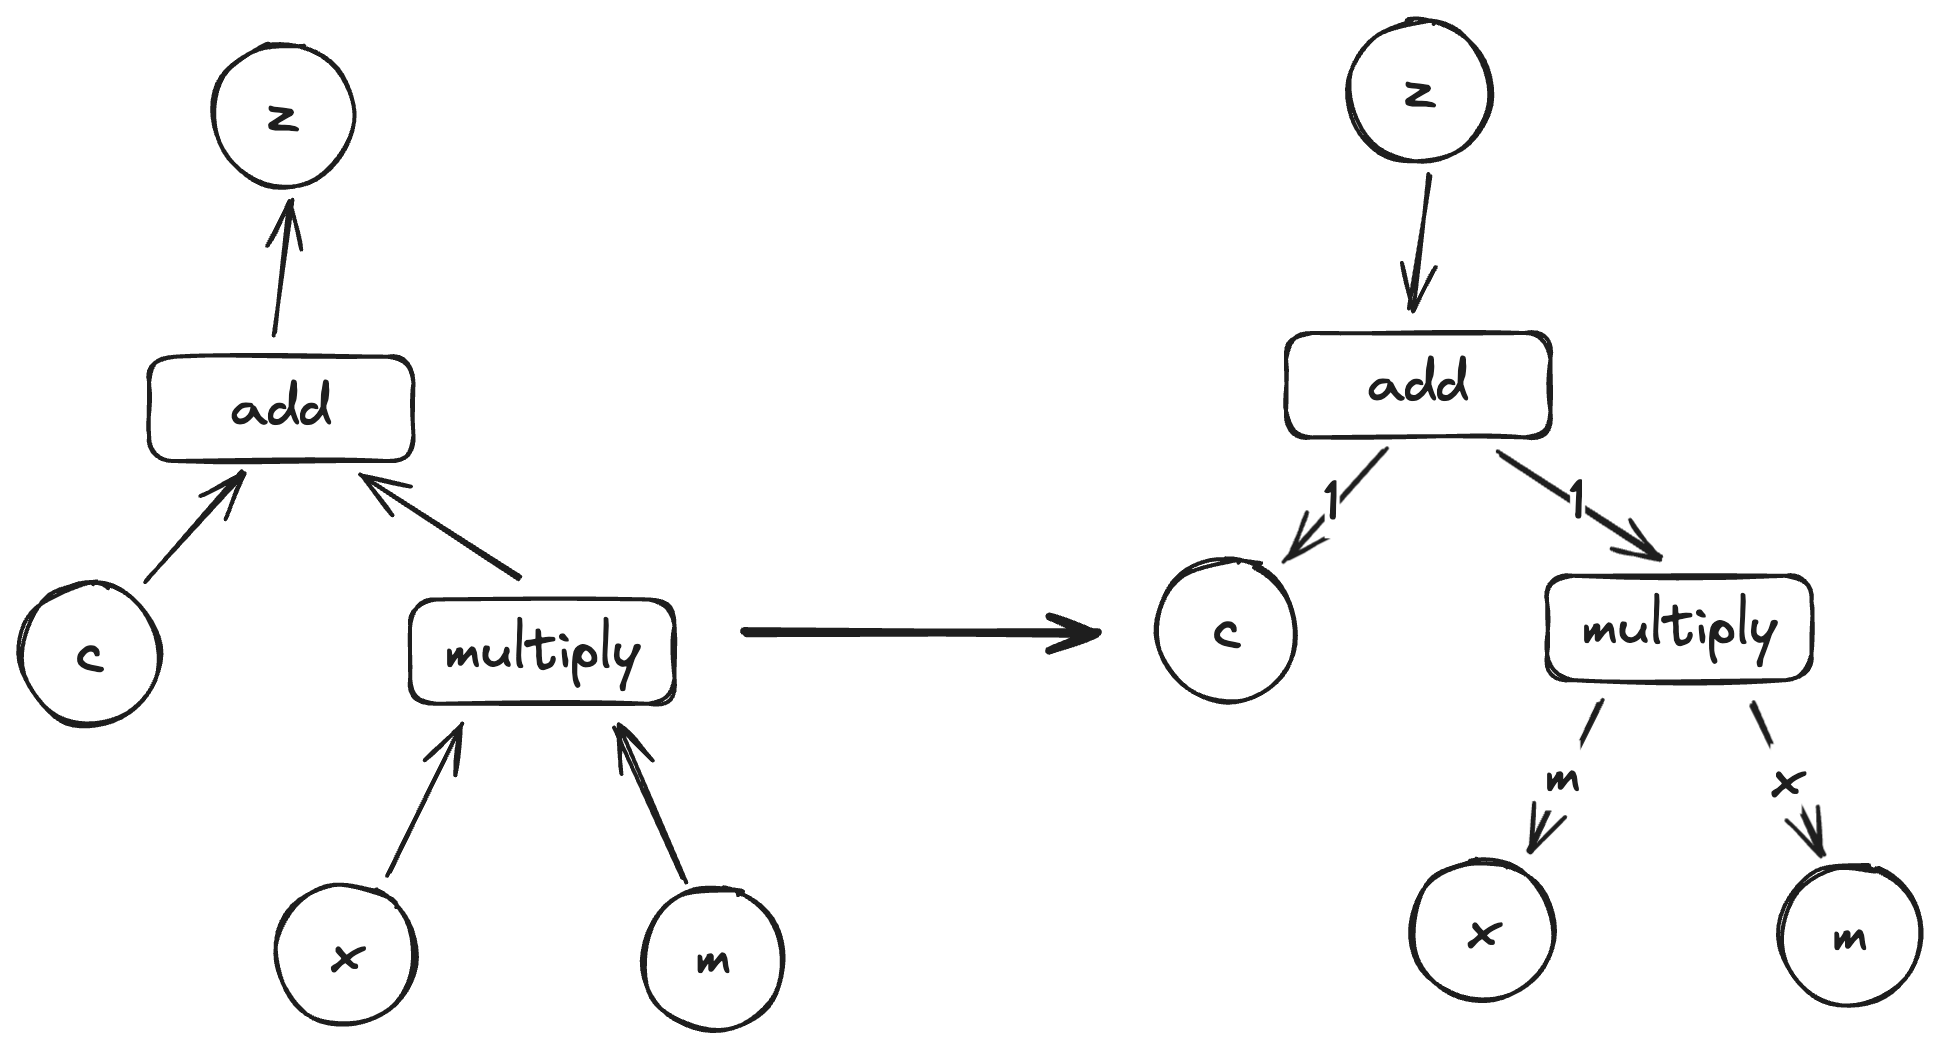

Then we can calculate the derivative of $z$ wrt one of the input variables (e.g $x$) by starting at $z$ and following the path to the variable, multiplying all the derivatives that we pass through on the way.

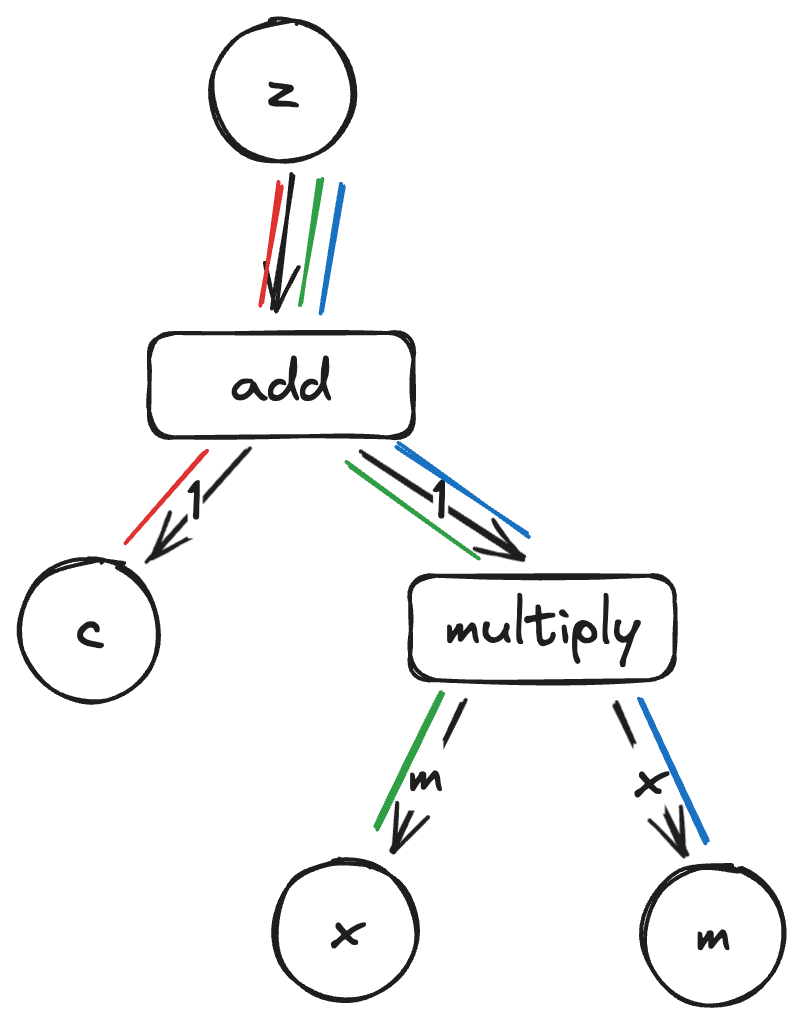

If we follow the green path, we find that the derivative wrt $x$ is $1 \times m = m$ and sure enough, $\frac{\partial z}{\partial x} = m$. Similarly, we find that the red path gives us $\frac{\partial z}{\partial c} = 1$ and the blue path gives us $\frac{\partial z}{\partial m} = x$.

We havent yet handled situations where a variable is used as more than one of the inputs to a function. In this situation, we get multiple paths through the diagram to the same variable. For example $z = (x + c)x$ has the graph:

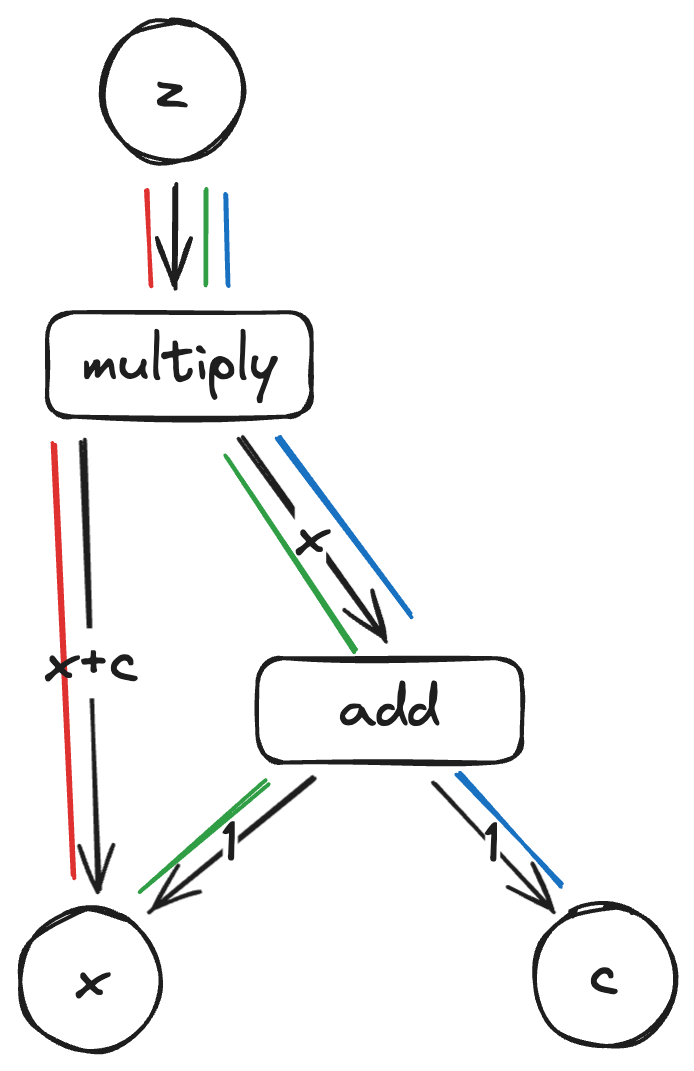

We can get from $z$ to $x$ via the green path and the red path.

In this situation, we can look back through the identities from earlier and see that if 
$$z = f(g(x), h(x))$$ 
then
$$\frac{\partial z}{\partial x} =\frac{\partial f(u)}{\partial u}\frac{\partial g(x)}{\partial x} + \frac{\partial f(u)}{\partial u}\frac{\partial h(x)}{\partial x}$$

This means that if we have multiple paths to a variable, we can multiply all the derivatives for each path and then add the result for each path together. In this case, if we want to find $\frac{\partial z}{\partial x}$ we can add the derivatives for the green path and the red path together to get:

$$(x+c) + x = 2x + c$$

If we work out the derivative algebraically:

$$\frac{\partial z}{\partial x} = \frac{\partial}{\partial x}((x+c)x) = \frac{\partial}{\partial x}(x^2 + cx) = \frac{\partial x^2}{\partial x} + c\frac{x}{\partial x} = 2x + c$$

We can see that it works!

To summarise, we have invented the following algorithm for calculating of a variable wrt its inputs:

1. Turn the equation into a graph # TODO intro graphs
2. Flip the direction of the arrows and draw the appropriate derivatives on the arrows
3. Find every path from the output to the input variable you care about
4. Follow each path and multiply the derivatives you pass through
5. Add together the results for each path

We have an algorithm in pictures and words, lets turn it into code.

### The Algorithm™

We have actually already converted our functions into graphs. If you recall earlier, when we generate a tensor from an operation, we recorded the arguments to the operation. This means the we have edges from the output tensor from and operation to the input tensors of the operation. 

We also stored the functions to calculate derivatives along each of these edges which means that we have also completed part 2 of our algorithm.

This means that our next challenge is to find all paths from the tensor we want to differentiate to the input tensors that created it. Because none of our operations are self referential (outputs are never fed back in as inputs), and all of our edges have a direction, our graph of operations is a special type of graph called a directed acyclic graph or DAG. This means that we can find all paths to every parameter pretty easily with a Breadth First Search (or Depth First Search but BFS is better for an algorithm we'll run later).

Lets recreate that giant diagram we made earlier. We can do this by first calculating $L$ from the inputs

In [13]:
y = Tensor(1)
m = Tensor(2)
x = Tensor(3)
c = Tensor(4)

# L = (y - (mx + c))^2
left = _sub(y, _add(_mul(m, x), c))
right = _sub(y, _add(_mul(m, x), c))

L = _mul(left, right)

# Attaching names to tensors will make our
# picture look nicer
y.name = "y"
m.name = "m"
x.name = "x"
c.name = "c"
L.name = "L"

And then using Breadth First Search to do 3 things:
 - Find all nodes
 - Find all edges
 - Find all paths from $L$ to our parameters

In [14]:
edges = []

stack = [(L, [L])]

# the 
node_hashes
nodes = []
edges = []
while stack:
    node, current_path = stack.pop()
    # Record nodes we havent seen before
    if hash(node) not in [hash(n) for n in nodes]:
        nodes.append(node)

    # if we have reached a parameter (it has no arguments
    # because it wasn't created by an operation) then
    # record the path taken to get here
    if not node.args:
        if not hasattr(node, "paths"):
            node.paths = []
        node.paths.append(current_path)
        continue

    for arg in node.args:
        stack.append((arg, current_path + [arg]))
        # Record every new edge
        edges.append((hash(node), hash(arg)))

Now we've got all of the edges and nodes, we have complete knowledge of our computational graph. This is all we need algorithmically but lets also use a graphing library to visualise it so we understand what is going on.

/var/folders/5j/tq3_y7t11b9gmgwyjyl9v1dm0000gn/T/ipykernel_91643/980730084.py:16: DeprecationWarning: nx.nx_pydot.graphviz_layout depends on the pydot package, which has known issues and is not actively maintained. Consider using nx.nx_agraph.graphviz_layout instead.

See https://github.com/networkx/networkx/issues/5723
  pos = graphviz_layout(graph, prog="dot")


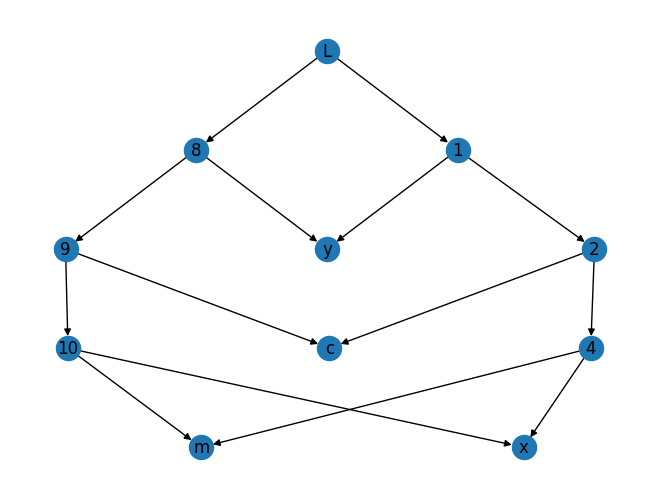

In [15]:
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout

# Assign a unique integer to each
# unnamed node so we know which
# node is which in the picture
labels = {}
for i, node in enumerate(nodes):
    if hasattr(node, "name"):
        labels[hash(node)] = node.name
    else:
        labels[hash(node)] = str(i)

graph = nx.DiGraph()
graph.add_edges_from(edges)
pos = graphviz_layout(graph, prog="dot")
nx.draw(graph, pos=pos, labels=labels)

If you squint a bit, you can see that this looks like to the graph we made earlier. Lets take a look at the paths the algorithm found from $L$ to $x$.

In [16]:
for path in x.paths:
    steps = []
    for step in path:
        steps.append(labels[hash(step)])
    print("->".join(steps))

L->1->2->4->x
L->8->9->10->x


The paths look correct! All we need to do now is to modify the algorithm a bit to keep track of the derivatives along each path. The word derivative is quite long so lets copy pytorch and use the `grad` (short for gradient) instead.

In [17]:
edges = []

stack = [(L, [L], [])]

nodes = []
edges = []
while stack:
    node, current_path, current_derivative = stack.pop()
    # Record nodes we havent seen before
    if hash(node) not in [hash(n) for n in nodes]:
        nodes.append(node)

    # if we have reached a parameter (it has no arguments
    # because it wasn't created by an operation) then
    # record the path taken to get here
    if not node.args:
        if not hasattr(node, "paths"):
            node.paths = []
        node.paths.append(current_path)
        if not hasattr(node, "grads"):
            node.grads = []
        node.grads.append(current_derivative)
        continue

    for arg, op in zip(node.args, node.derivatives):
        stack.append((arg, current_path + [arg], current_derivative + [op]))
        # Record every new edge
        edges.append((hash(node), hash(arg)))

Lets check if the derivatives were recorded correctly.

In [18]:
x.grads

[[Tensor(-9), Tensor(-1), Tensor(1), Tensor(2)],
 [Tensor(-9), Tensor(-1), Tensor(1), Tensor(2)]]

Looks reasonable so far. We have 2 identical paths, each with 4 derivatives (one for each edge in the path) as expected.

Lets multiply the derivatives together along each path and add the total for each path together and see if we get the right answer. According to wolfram alpha (and the peice of paper in front of me) the derivative of $L$ wrt $x$ is:
$$\frac{\partial L}{\partial x} = 2m (c + mx - y)$$
Plugging the values for our tensors in, we get
$$2\times2 (4 + (2\times3) - 1) = 36$$

In [19]:
total_grad = Tensor(0)
for chain in x.grads:
    chain_total = Tensor(1)
    for step in chain:
        chain_total = _mul(chain_total, step)
    total_grad = _add(total_grad, chain_total)

total_grad

Tensor(36)

The correct answer! It looks like our algorithm works. All that remains is to put it all together.

## Putting it all together

When dreaming up the algorithm, we kept a record of the nodes and edges we visited as well as the path we followed so we could plot them and check that everything was working. Now that we know that it works, we can remove these steps.

In [20]:
def backward(root_node: Tensor) -> None:
    stack = [(root_node, [])]

    while stack:
        node, current_derivative = stack.pop()

        # if we have reached a parameter (it has no arguments
        # because it wasn't created by an operation) then
        # record the path taken to get here
        if not node.args:
            if not hasattr(node, "grads"):
                node.grads = []
            node.grads.append(current_derivative)
            continue

        for arg, op in zip(node.args, node.derivatives):
            stack.append((arg, current_derivative + [op]))

There is also no need (for now) to store the derivatives and calculate them separately. Instead, we can avoid a bunch of repeated calculations by multiplying the derivatives as we go

In [21]:
def backward(root_node: Tensor) -> None:
    stack = [(root_node, Tensor(1))]

    while stack:
        node, current_derivative = stack.pop()

        # if we have reached a parameter (it has no arguments
        # because it wasn't created by an operation) then add the
        # derivative
        if not node.args:
            if not hasattr(node, "grad") or node.grad is None:
                node.grad = Tensor(0)
            node.grad = _add(node.grad, current_derivative)
            continue

        for arg, derivative in zip(node.args, node.derivatives):
            stack.append((arg, _mul(current_derivative, derivative)))

In [22]:
# Make sure our algorithm still gives the right answer
y = Tensor(1)
m = Tensor(2)
x = Tensor(3)
c = Tensor(4)

left = _sub(y, _add(_mul(m, x), c))
right = _sub(y, _add(_mul(m, x), c))

L = _mul(left, right)
backward(L)

assert x.grad == Tensor(36), x.grad

To make the a bit easier to use, lets put this in our Tensor object

In [23]:
class Tensor:
    """
    A float that can be differentiated
    """

    args: tuple["Tensor"] = ()
    derivatives: tuple["Tensor"] | None = None
    # The derivative (once we've calculated it). This is None if the derivative
    # has not been computed yet
    grad: Optional["Tensor"] = None

    def __init__(self, value: float):
        self.value = value

    def __repr__(self) -> str:
        return f"Tensor({self.value.__repr__()})"

    def backward(self):
        if self.args is None or self.derivatives is None:
            raise ValueError(
                "Cannot differentiate a Tensor that is not a function of other Tensors"
            )

        stack = [(self, Tensor(1))]

        while stack:
            node, current_derivative = stack.pop()

            # if we have reached a parameter (it has no arguments
            # because it wasn't created by an operation) then add the
            # derivative
            if not node.args:
                if not hasattr(node, "grad") or node.grad is None:
                    node.grad = Tensor(0)
                node.grad = _add(node.grad, current_derivative)
                continue

            for arg, derivative in zip(node.args, node.derivatives):
                new_derivative = _mul(current_derivative, derivative)
                stack.append((arg, new_derivative))

Lets try it out

In [24]:
y = Tensor(1)
m = Tensor(2)
x = Tensor(3)
c = Tensor(4)

left = _sub(y, _add(_mul(m, x), c))
right = _sub(y, _add(_mul(m, x), c))

L = _mul(left, right)
L.backward()

assert x.grad.value == Tensor(36).value, x.grad

I don't know about you, but I think that all of these `_add` and `_mul` functions everywhere aren't exactly ergonomic. We can fix this by adding some special functions to our tensor. The simplest of these is `__eq__` that will let us compare two tensors. 

In [25]:
def __eq__(self, other) -> bool:
    if not isinstance(other, "Tensor"):
        raise TypeError(f"Cannot compare a Tensor with a {type(other)}")
    return self.value == other.value

Next, can also add `__add__`, `__sub__` and `__mul__` methods to allow us to use the `+`, `-` and `*` operators respectively.

In [26]:
def __add__(self, other) -> "Tensor":
    if not isinstance(other, "Tensor"):
        raise TypeError(f"Cannot add a Tensor to a {type(other)}")
    return _add(self, other)


def __sub__(self, other) -> "Tensor":
    if not isinstance(other, "Tensor"):
        raise TypeError(f"Cannot subtract a Tensor from a {type(other)}")
    return _sub(self, other)


def __mul__(self, other) -> "Tensor":
    if not isinstance(other, "Tensor"):
        raise TypeError(f"Cannot multiply a Tensor with a {type(other)}")
    return _mul(self, other)

Finally, we can add the `__iadd__`, `__isub__` and `__imul__` methods to allow us to use `+=`, `-=` and `*=`.

In [27]:
def __iadd__(self, other) -> "Tensor":
    self = self.__add__(self, other)
    return self


def __isub__(self, other) -> "Tensor":
    self = self.__sub__(self, other)
    return self


def __imul__(self, other) -> "Tensor":
    self = self.__mul__(self, other)
    return self

These let us clean up our backward function a bit

In [28]:
def backward(self):
    if self.args is None or self.derivatives is None:
        raise ValueError(
            "Cannot differentiate a Tensor that is not a function of other Tensors"
        )

    stack = [(self, Tensor(1))]

    while stack:
        node, current_derivative = stack.pop()

        # if we have reached a parameter (it has no arguments
        # because it wasn't created by an operation) then add the
        # derivative
        if not node.args:
            if not hasattr(node, "grad") or node.grad is None:
                node.grad = Tensor(0)
            node.grad += current_derivative
            continue

        for arg, derivative in zip(node.args, node.derivatives):
            stack.append((arg, current_derivative * derivative))

Putting all of these together, we get a final `Tensor` object as follows:

In [29]:
class Tensor:
    """
    A float that can be differentiated
    """

    args: tuple["Tensor"] = ()
    derivatives: tuple["Tensor"] | None = None
    # The derivative (once we've calculated it). This is None if the derivative
    # has not been computed yet
    grad: Optional["Tensor"] = None

    def __init__(self, value: float):
        self.value = value

    def __repr__(self) -> str:
        return f"Tensor({self.value.__repr__()})"

    def __eq__(self, other) -> bool:
        if not isinstance(other, Tensor):
            raise TypeError(f"Cannot compare a Tensor with a {type(other)}")
        return self.value == other.value

    def __add__(self, other) -> "Tensor":
        if not isinstance(other, Tensor):
            raise TypeError(f"Cannot add a Tensor to a {type(other)}")
        return _add(self, other)

    def __sub__(self, other) -> "Tensor":
        if not isinstance(other, Tensor):
            raise TypeError(f"Cannot subtract a Tensor from a {type(other)}")
        return _sub(self, other)

    def __mul__(self, other) -> "Tensor":
        if not isinstance(other, Tensor):
            raise TypeError(f"Cannot multiply a Tensor with a {type(other)}")
        return _mul(self, other)

    def __iadd__(self, other) -> "Tensor":
        return self.__add__(other)

    def __isub__(self, other) -> "Tensor":
        return self.__sub__(other)

    def __imul__(self, other) -> "Tensor":
        return self.__mul__(other)

    def backward(self):
        if self.args is None or self.derivatives is None:
            raise ValueError(
                "Cannot differentiate a Tensor that is not a function of other Tensors"
            )

        stack = [(self, Tensor(1))]

        while stack:
            node, current_derivative = stack.pop()

            # if we have reached a parameter (it has no arguments
            # because it wasn't created by an operation) then add the
            # derivative
            if not node.args:
                if not hasattr(node, "grad") or node.grad is None:
                    node.grad = Tensor(0)
                node.grad += current_derivative
                continue

            for arg, derivative in zip(node.args, node.derivatives):
                stack.append((arg, current_derivative * derivative))

Lets take it for a spin. We'll try calculating $L$ again

In [30]:
y = Tensor(1)
m = Tensor(2)
x = Tensor(3)
c = Tensor(4)

diff = y - ((m * x) + c)
L = diff * diff
L.backward()

assert x.grad == Tensor(36)

Much easier!

To really see what this baby can do, I asked chatgpt for the most complicated expression it could think of and it gave me this:

$$f(x) = (2x^3 + 4x^2 - 5x) \times (3x^2 - 2x + 7) - (6x^4 + 2x^3 - 8x^2) + (5x^2 - 3x)$$
According to wolfram alpha, the derivative of this expression is:
$$\frac{d f(x)}{dx} = -38 + 102 x - 33 x^2 + 8 x^3 + 30 x^4$$

If we plug 2 into this equation, the answer is apparently 578.

Lets try it with our algorithm

In [89]:
x = Tensor(2)

y = (
    (Tensor(2) * x * x * x + Tensor(4) * x * x - Tensor(5) * x)
    * (Tensor(3) * x * x - Tensor(2) * x + Tensor(7))
    - (Tensor(6) * x * x * x * x + Tensor(2) * x * x * x - Tensor(8) * x * x)
    + (Tensor(5) * x * x - Tensor(3) * x)
)

y.backward()

assert x.grad == Tensor(578)

Once again, we got the right answer!

# Conclusion
To conclude, we have now written an algorithm that will let us differentiate any mathematical expression, provided it only involves addition, subtraction and multiplication. We did this by converting our expression into a graph and reimagining partial derivatives as operations on the edges of that graph. Then we found that could apply Breadth First Search to combine all the derivatives together to get a final answer.

Now that we have a library that can differentiate simple expressions, the next logical question is whether we can make it any better and the answer is yes we can. In the next post, we'll figure out how to extend our algorithm to vectors and matrices and we'll use that knowledge to build up to a functioning neural network.